In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import pandas as pd
import warnings
import os
warnings.filterwarnings('ignore')

In [2]:
# check if filename already exists, if so add number
def check_filename(filename):
    filename = "figs/" +  filename
    if os.path.exists(filename + ".png"):
        i = 1
        while True:
            new_filename = filename + "_" + str(i)
            if os.path.exists(new_filename + ".png"):
                i += 1
            else:
                return new_filename + ".png"
    else:
        return filename + ".png"
    
# save figure
def save_figure(fig, filename):
    filename = check_filename(filename)
    fig.savefig(filename)
    print(f'Figure saved as {filename}')

Satelli sampling means variance based sampling, but not a good measure for non-uniform distribution. Advantage: just extends series further if you want to increase number of samples
Parallelization of sampling --> batch run (concurrent)

# Added modules

In [3]:
def get_theta(x, mu, sigma):
    """
    x: fraction of similar neighbours
    mu: optimal fraction of similar neighbours
    sigma: acceptance range
    """
    theta = np.exp(-((x - mu) ** 2) / (2 * sigma ** 2))
    return theta

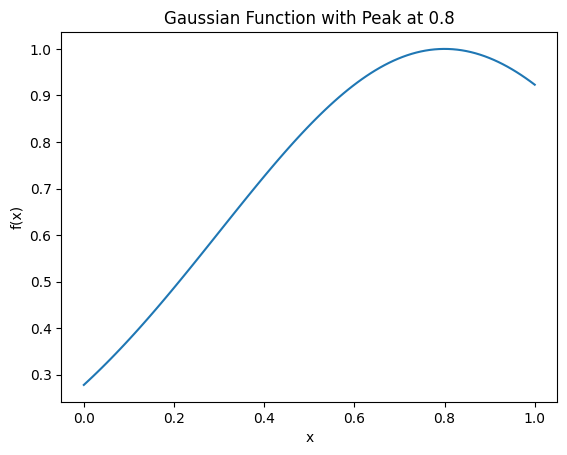

In [4]:
def gaussian_function(x, mu, sigma):
    return np.exp(-((x - mu) ** 2) / (2 * sigma ** 2))

# Example usage:
x_values = np.linspace(0, 1, 100)
mu = 0.8  # Peak in the middle
sigma = 0.5  # Controls the width

y_values = gaussian_function(x_values, mu, sigma)

# You can plot the function to visualize it
import matplotlib.pyplot as plt

plt.plot(x_values, y_values)
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title(f'Gaussian Function with Peak at {mu}')
plt.show()

#save_figure(plt, f'Gaussian Function with Peak at {mu}')

# Sobol Sensitivity Analysis

In [5]:
from SALib.sample import saltelli
from SALib.analyze import sobol

In [6]:
import modules as modules
import model as model
from model import Schelling

def schelling_SA(num_runs, num_steps, burn_in_period, density, minority_pc, property_value_weight, alpha, mu_theta, sigma_theta):

    # initialize storage for parameters
    overall_desirability_entropy = []
    overall_agent_entropy = []
    overall_utility = []

    # run the model several times for the same parameter setting 
    for _ in range(num_runs):

        # initialize model
        models = Schelling(
            property_value_func=modules.property_value_from_gdf,
            income_func=modules.income_func,
            desirability_func=modules.desirability_func,
            utility_func=modules.utility_func,
            price_func=modules.price_func,
            compute_similar_neighbours=modules.compute_similar_neighbours,
            calculate_gi_star = modules.calculate_gi_star,
            update_interested_agents_func = modules.update_interested_agents_concurrently,
            price_func_cap=modules.price_func_cap,
            height=20,
            width=20,
            radius=1,
            density=density,
            minority_pc=minority_pc,
            alpha=alpha,
            income_scale=1.5, # the scale by which the income is higher than the property value
            property_value_weight=property_value_weight,
            mu_theta = mu_theta,
            sigma_theta = sigma_theta,
            seed=42)

        # Run the model for a certain number of steps
        for _ in range(num_steps):
            models.step()

        # call necessary data collectors
        agent_data = models.datacollector.get_agent_vars_dataframe()
        model_data_entropy = models.datacollector.get_model_vars_dataframe()
    
        # Compute mean and standard deviation of entropies over time per run
        desirability_entropy = model_data_entropy['Desirability entropy'].to_numpy()
        # desirability_entropy_std = model_data_entropy['Desirability entropy'].std()
        mean_desirability_entropy = np.mean(desirability_entropy[burn_in_period::])
    
        agent_entropy = model_data_entropy['Agent entropy'].to_numpy()
        # agent_entropy_std = model_data_entropy['Agent entropy'].std()
        mean_agent_entropy = np.mean(agent_entropy[burn_in_period::])
        
        # Compute mean and standard deviation of utility per time step over each agent 
        utility_mean = agent_data.groupby(level='Step')['Utility'].mean()
        #utility_std = agent_data.groupby(level='Step')['Utility'].std()
    
        # Compute mean and standard deviation of utility over time 
        utility_mean = pd.DataFrame(utility_mean).to_numpy()
        #utility_std = pd.DataFrame(utility_std).to_numpy()
        mean_utility_interim = np.mean(utility_mean[burn_in_period::])

        # Append all results to storage
        overall_desirability_entropy.append(mean_desirability_entropy)
        overall_agent_entropy.append(mean_agent_entropy)
        overall_utility.append(mean_utility_interim)

    mean_desirability = np.mean(overall_desirability_entropy)
    mean_agent = np.mean(overall_agent_entropy)
    mean_utility = np.mean(overall_utility)

    return mean_desirability, mean_agent, mean_utility

In [7]:
# Step 1: Problem definition
problem = {
    'num_vars': 6,
    'names': ['density', 'minority_pc', 'property_value_weight', 'alpha', 'mu_theta', 'sigma_theta'],
    'bounds': [[0,1], [0,1], [0,1], [0,1], [0,1], [0,1]]
}

# Step 2: Generate samples 
samples = saltelli.sample(problem, 25) 

In [8]:
# Step 3: evaluate the model under the different parameter settings 
# Define settings 
iterations = 30
model_steps = 30
burn_in = 5

# Initialize storage for measures
results_dict = {"desirability": {}, "agent": {}, "utility": {}}
# set dictionary keys for each sample
for i in range(len(samples)):
    results_dict["desirability"][i] = 0.0
    results_dict["agent"][i] = 0.0
    results_dict["utility"][i] = 0.0

# result_desirability = pd.DataFrame()
# result_agent = pd.DataFrame()
# result_utility = pd.DataFrame()

# # load csv files
# #isExist = os.path.exists('results/sa_desirability.csv')
# if os.path.exists('results/sa_desirability.csv'):
#     result_desirability = pd.read_csv('results/sa_desirability.csv', index_col=0).to_numpy().flatten()
#     result_agent = pd.read_csv('results/sa_agent.csv', index_col=0).to_numpy().flatten()
#     result_utility = pd.read_csv('results/sa_utility.csv', index_col=0).to_numpy().flatten()

#     # find the last row that is not 0.0
#     last_row = np.where(result_desirability == 0.0)[0][0]
# else:
#     last_row = 0

In [9]:
def save_model(results_dict, new_results_dict):
    print('Saving model...')

    # update results_dict with new_results_dict
    for type in new_results_dict.keys():
        for key in new_results_dict[type].keys():
            results_dict[type][key] = new_results_dict[type][key]

    # save results, use keys as index
    pd.DataFrame.from_dict(results_dict['desirability'], orient='index').to_csv('results/sa_desirability.csv', index=True)
    pd.DataFrame.from_dict(results_dict['agent'], orient='index').to_csv('results/sa_agent.csv', index=True)
    pd.DataFrame.from_dict(results_dict['utility'], orient='index').to_csv('results/sa_utility.csv', index=True)

    print('Model saved')
    return

# def evaluate_model(samples, result_desirability, result_agent, result_utility, iterations, model_steps, burn_in, last_row=0):
#     for i, X in enumerate(samples):
#         print(f'Iteration {i+1} out of {samples.shape[0]}')
#         if i < last_row:
#             print('Already computed')
#         else:
#             results = schelling_SA(iterations, model_steps, burn_in, *X)
#             result_desirability[i] = results[0]
#             result_agent[i] = results[1]
#             result_utility[i] = results[2]
#             save_model(result_desirability, result_agent, result_utility)
#     return

In [10]:
import concurrent.futures

def eval_model_step(i, sample, results_dict, iterations, model_steps, burn_in, last_row=0):
    print(f'Iteration {i+1} out of {samples.shape[0]}')
    if i < last_row:
        print('Already computed')
        return
    else:
        results = schelling_SA(iterations, model_steps, burn_in, *sample)
        results_dict = {
            "desirability": {i: results[0]}, 
            "agent": {i: results[1]}, 
            "utility": {i: results[2]}
        }
        print(results_dict)
        return results_dict
    
def run_model_parallel(samples, results_dict, iterations, model_steps, burn_in, last_row=0):
    with concurrent.futures.ProcessPoolExecutor() as executor:
        results = [executor.submit(eval_model_step, i, sample, results_dict, iterations, model_steps, burn_in, last_row) for i, sample in enumerate(samples)]
        for f in concurrent.futures.as_completed(results):
            new_result = f.result()
            save_model(results_dict, new_result)
    return

run_model_parallel(samples, results_dict, iterations, model_steps, burn_in)

Iteration 1 out of 350

Iteration 2 out of 350Iteration 3 out of 350Iteration 14 out of 350Iteration 4 out of 350Iteration 5 out of 350
Iteration 10 out of 350Iteration 18 out of 350
Iteration 13 out of 350Iteration 8 out of 350Iteration 6 out of 350Iteration 16 out of 350
Iteration 15 out of 350Iteration 7 out of 350Iteration 19 out of 350

Iteration 9 out of 350

Iteration 12 out of 350
Iteration 17 out of 350


Iteration 20 out of 350
Iteration 11 out of 350





{'desirability': {5: 1.1705268924401981}, 'agent': {5: 0.13998931208045082}, 'utility': {5: 0.6975063442832604}}
Iteration 21 out of 350
{'desirability': {3: 1.1693301294130596}, 'agent': {3: 0.1474317818366267}, 'utility': {3: 0.7810682724900369}}
Iteration 22 out of 350
Saving model...
Model saved
Saving model...
Model saved
{'desirability': {4: 1.1684659779111637}, 'agent': {4: 0.12545877588982174}, 'utility': {4: 0.49620974438467264}}
Iteration 23 out of 350
{'desirability': {2: 1.1710340633330614}, 'agent': {2: 0.09958

In [15]:
result_desirability = pd.DataFrame.from_dict(results_dict['desirability'], orient='index').to_numpy().flatten()
result_agent = pd.DataFrame.from_dict(results_dict['agent'], orient='index').to_numpy().flatten()
result_utility = pd.DataFrame.from_dict(results_dict['utility'], orient='index').to_numpy().flatten()

In [17]:
# Step 4: analyse results
Si_desirability = sobol.analyze(problem, result_desirability, print_to_console=True)

                             ST   ST_conf
density                0.816178  0.585990
minority_pc            0.030151  0.058634
property_value_weight  0.130977  0.129477
alpha                  0.030198  0.039725
mu_theta               0.129283  0.098577
sigma_theta            0.029638  0.035177
                             S1   S1_conf
density                0.760790  0.496435
minority_pc            0.034629  0.054295
property_value_weight -0.120146  0.281055
alpha                  0.092409  0.108827
mu_theta              -0.207873  0.235719
sigma_theta           -0.070403  0.079973
                                            S2   S2_conf
(density, minority_pc)                0.080108  0.442582
(density, property_value_weight)      0.137912  0.519048
(density, alpha)                     -0.078282  0.403075
(density, mu_theta)                   0.249649  0.755795
(density, sigma_theta)                0.240859  0.617835
(minority_pc, property_value_weight) -0.011090  0.095017
(minority_pc,

In [18]:
Si_agent = sobol.analyze(problem, result_agent, print_to_console=True)

                             ST   ST_conf
density                0.821739  0.552140
minority_pc            0.041869  0.049482
property_value_weight  0.019878  0.016844
alpha                  0.064207  0.078714
mu_theta               0.279301  0.281467
sigma_theta            0.076030  0.091906
                             S1   S1_conf
density                0.806505  0.664564
minority_pc           -0.019125  0.091091
property_value_weight -0.032937  0.046105
alpha                  0.096193  0.125678
mu_theta               0.020757  0.176491
sigma_theta            0.032627  0.105695
                                            S2   S2_conf
(density, minority_pc)               -0.211908  0.875681
(density, property_value_weight)     -0.233013  0.851029
(density, alpha)                     -0.288210  0.927678
(density, mu_theta)                  -0.165277  0.959524
(density, sigma_theta)               -0.306413  0.902634
(minority_pc, property_value_weight) -0.050909  0.149453
(minority_pc,

In [19]:
Si_utility = sobol.analyze(problem, result_utility, print_to_console=True)

                             ST   ST_conf
density                0.023664  0.031229
minority_pc            0.002627  0.001616
property_value_weight  0.035350  0.026497
alpha                  0.318346  0.296108
mu_theta               0.276231  0.192729
sigma_theta            0.385742  0.270729
                             S1   S1_conf
density               -0.029085  0.049015
minority_pc           -0.010679  0.042340
property_value_weight  0.020796  0.099545
alpha                  0.120609  0.274518
mu_theta               0.200732  0.380915
sigma_theta            0.487449  0.539148
                                            S2   S2_conf
(density, minority_pc)                0.061038  0.073777
(density, property_value_weight)      0.071969  0.081435
(density, alpha)                      0.163273  0.253536
(density, mu_theta)                  -0.006610  0.132434
(density, sigma_theta)                0.152041  0.266061
(minority_pc, property_value_weight) -0.014648  0.063221
(minority_pc,

In [20]:
# Step 5: Plots
# Set params generally for all plots
params = ['Density', 'Minority Percentage', 'Weight: property value', r"$\alpha$", r"$\mu$", r"$\sigma$"]

In [21]:
# Generate plots for first and total order 
# First we do that for desirability
S1_desirability = Si_desirability['S1']
S1_conf_desirability = Si_desirability['S1_conf']

ST_desirability = Si_desirability['ST']
ST_conf_desirability = Si_desirability['ST_conf']

# Convert confidence intervals to errors (assuming symmetrical errors)
S1_err_desirability = np.array(S1_conf_desirability)
ST_err_desirability = np.array(ST_conf_desirability)

# Second for agent entropy
S1_agent = Si_agent['S1']
S1_conf_agent = Si_agent['S1_conf']

ST_agent = Si_agent['ST']
ST_conf_agent = Si_agent['ST_conf']

# Convert confidence intervals to errors (assuming symmetrical errors)
S1_err_agent = np.array(S1_conf_agent)
ST_err_agent = np.array(ST_conf_agent)

# Finally for utility
S1_utility = Si_utility['S1']
S1_conf_utility = Si_utility['S1_conf']

ST_utility = Si_utility['ST']
ST_conf_utility = Si_utility['ST_conf']

# Convert confidence intervals to errors (assuming symmetrical errors)
S1_err_utility = np.array(S1_conf_utility)
ST_err_utility = np.array(ST_conf_utility)

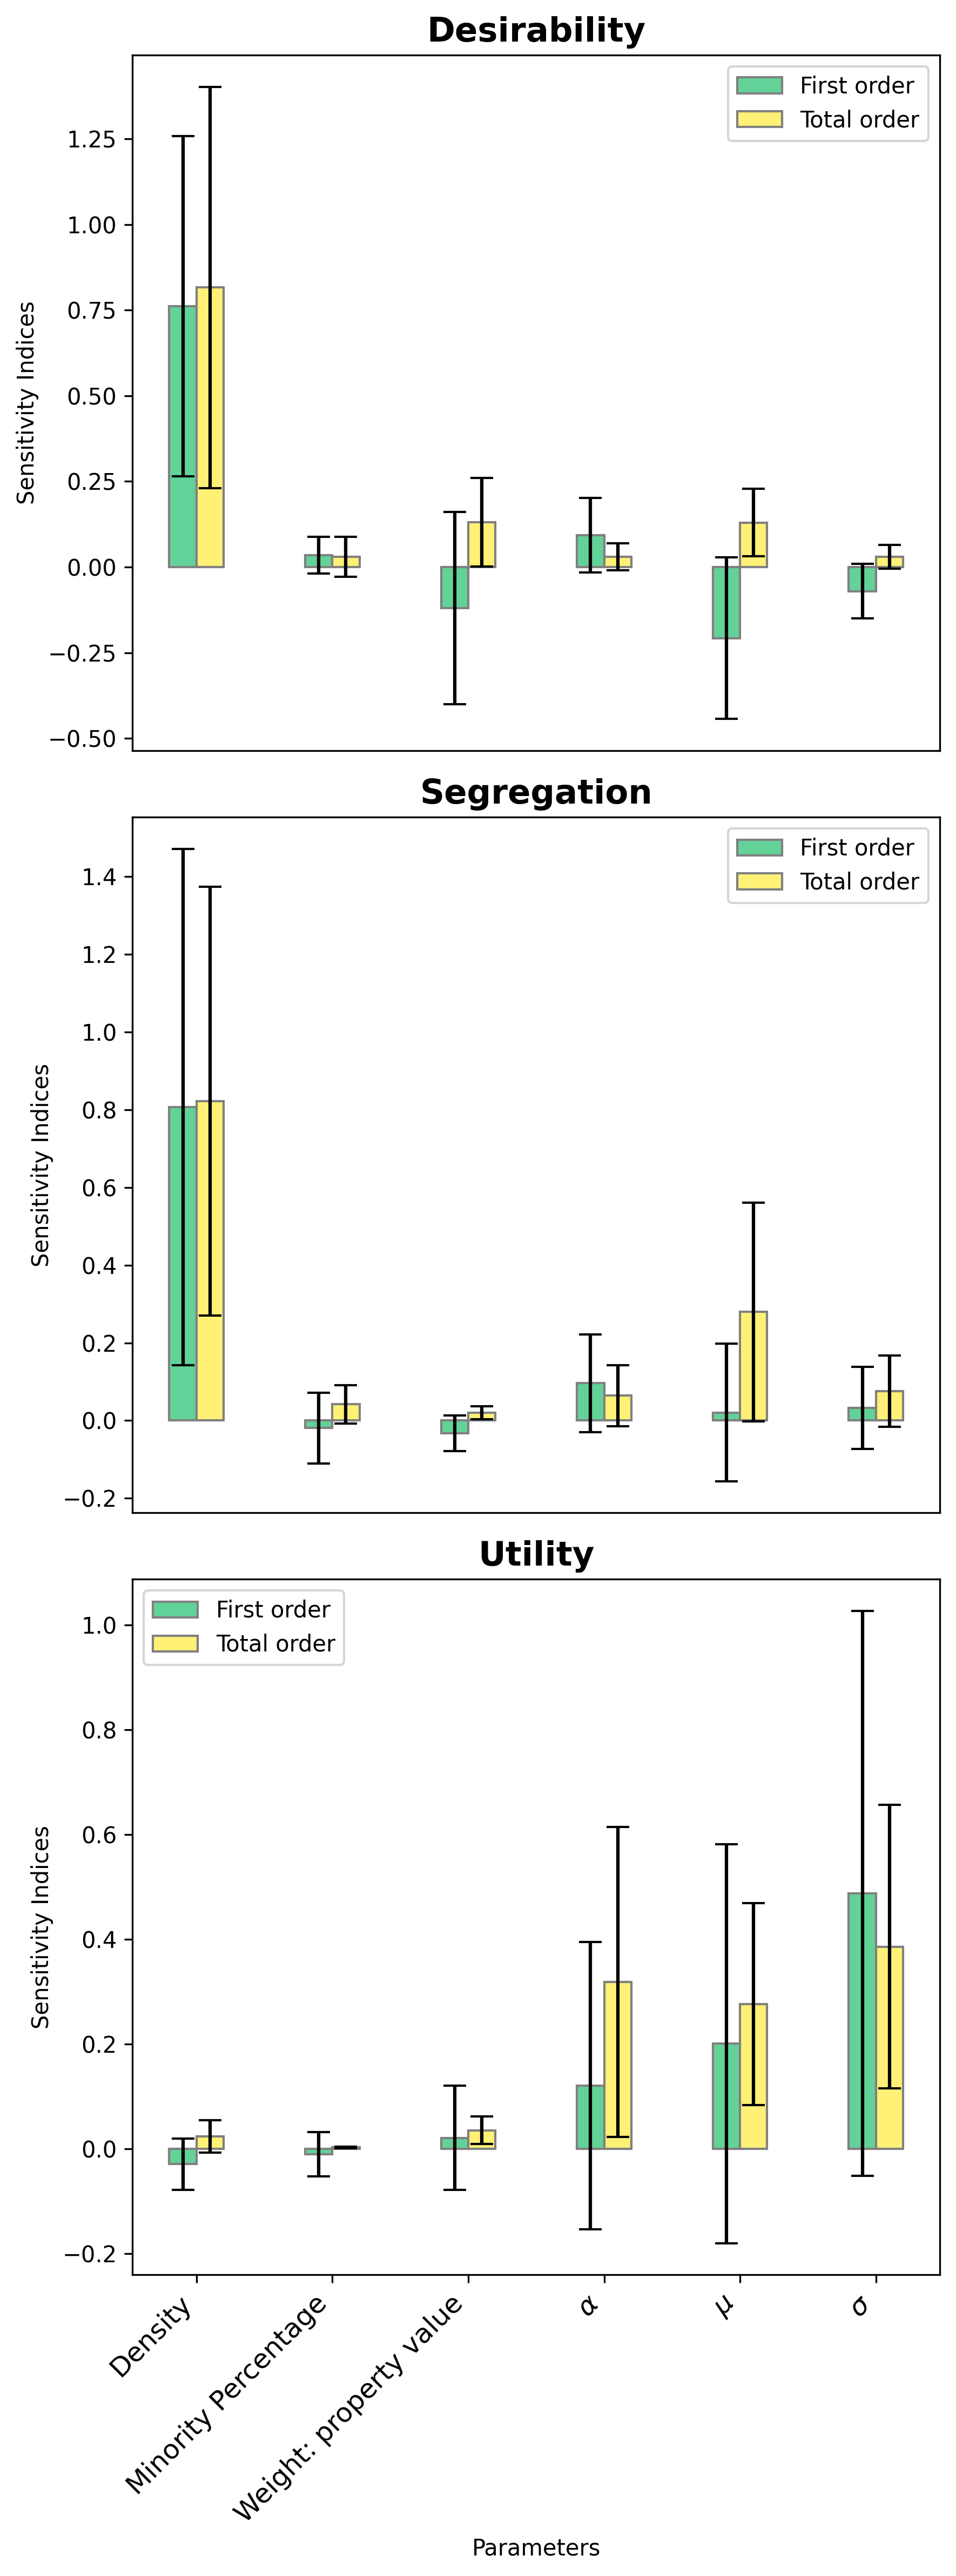

FileNotFoundError: [Errno 2] No such file or directory: 'figs/Utility.png'

<Figure size 640x480 with 0 Axes>

In [22]:
# Define plot settings
# Bar width
bar_width = 0.2

# Positions of the bars
r1 = np.arange(len(params))
r2 = [x + bar_width for x in r1]

# Create a figure with 3 subplots
fig, axs = plt.subplots(3, 1, dpi=300, figsize=(6, 16))

# Desirability subplot
axs[0].bar(r1, S1_desirability, yerr=S1_err_desirability, capsize=5, color='#63d298ff', width=bar_width, edgecolor='grey', label='First order')
axs[0].bar(r2, ST_desirability, yerr=ST_err_desirability, capsize=5, color='#fff176ff', width=bar_width, edgecolor='grey', label='Total order')
#axs[0].set_xlabel('Parameters', fontsize=10)
axs[0].set_ylabel('Sensitivity Indices', fontsize=10)
axs[0].set_title('Desirability', fontweight='bold', fontsize=15)
axs[0].set_xticks([]) 
#axs[0].set_xticks([r + bar_width/2 for r in range(len(params))])
#axs[0].set_xticklabels(params, rotation=45, ha='right', fontsize=12)
axs[0].legend()

# Segregation subplot
axs[1].bar(r1, S1_agent, yerr=S1_err_agent, capsize=5, color='#63d298ff', width=bar_width, edgecolor='grey', label='First order')
axs[1].bar(r2, ST_agent, yerr=ST_err_agent, capsize=5, color='#fff176ff', width=bar_width, edgecolor='grey', label='Total order')
#axs[1].set_xlabel('Parameters', fontsize=10)
axs[1].set_ylabel('Sensitivity Indices', fontsize=10)
axs[1].set_title('Segregation', fontweight='bold', fontsize=15)
axs[1].set_xticks([]) 
#axs[1].set_xticks([r + bar_width/2 for r in range(len(params))])
#axs[1].set_xticklabels(params, rotation=45, ha='right', fontsize=12)
axs[1].legend()

# Utility subplot
axs[2].bar(r1, S1_utility, yerr=S1_err_utility, capsize=5, color='#63d298ff', width=bar_width, edgecolor='grey', label='First order')
axs[2].bar(r2, ST_utility, yerr=ST_err_utility, capsize=5, color='#fff176ff', width=bar_width, edgecolor='grey', label='Total order')
axs[2].set_xlabel('Parameters', fontsize=10)
axs[2].set_ylabel('Sensitivity Indices', fontsize=10)
axs[2].set_title('Utility', fontweight='bold', fontsize=15)
axs[2].set_xticks([r + bar_width/2 for r in range(len(params))])
axs[2].set_xticklabels(params, rotation=45, ha='right', fontsize=12)
axs[2].legend()

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

save_figure(plt, f'Utility')

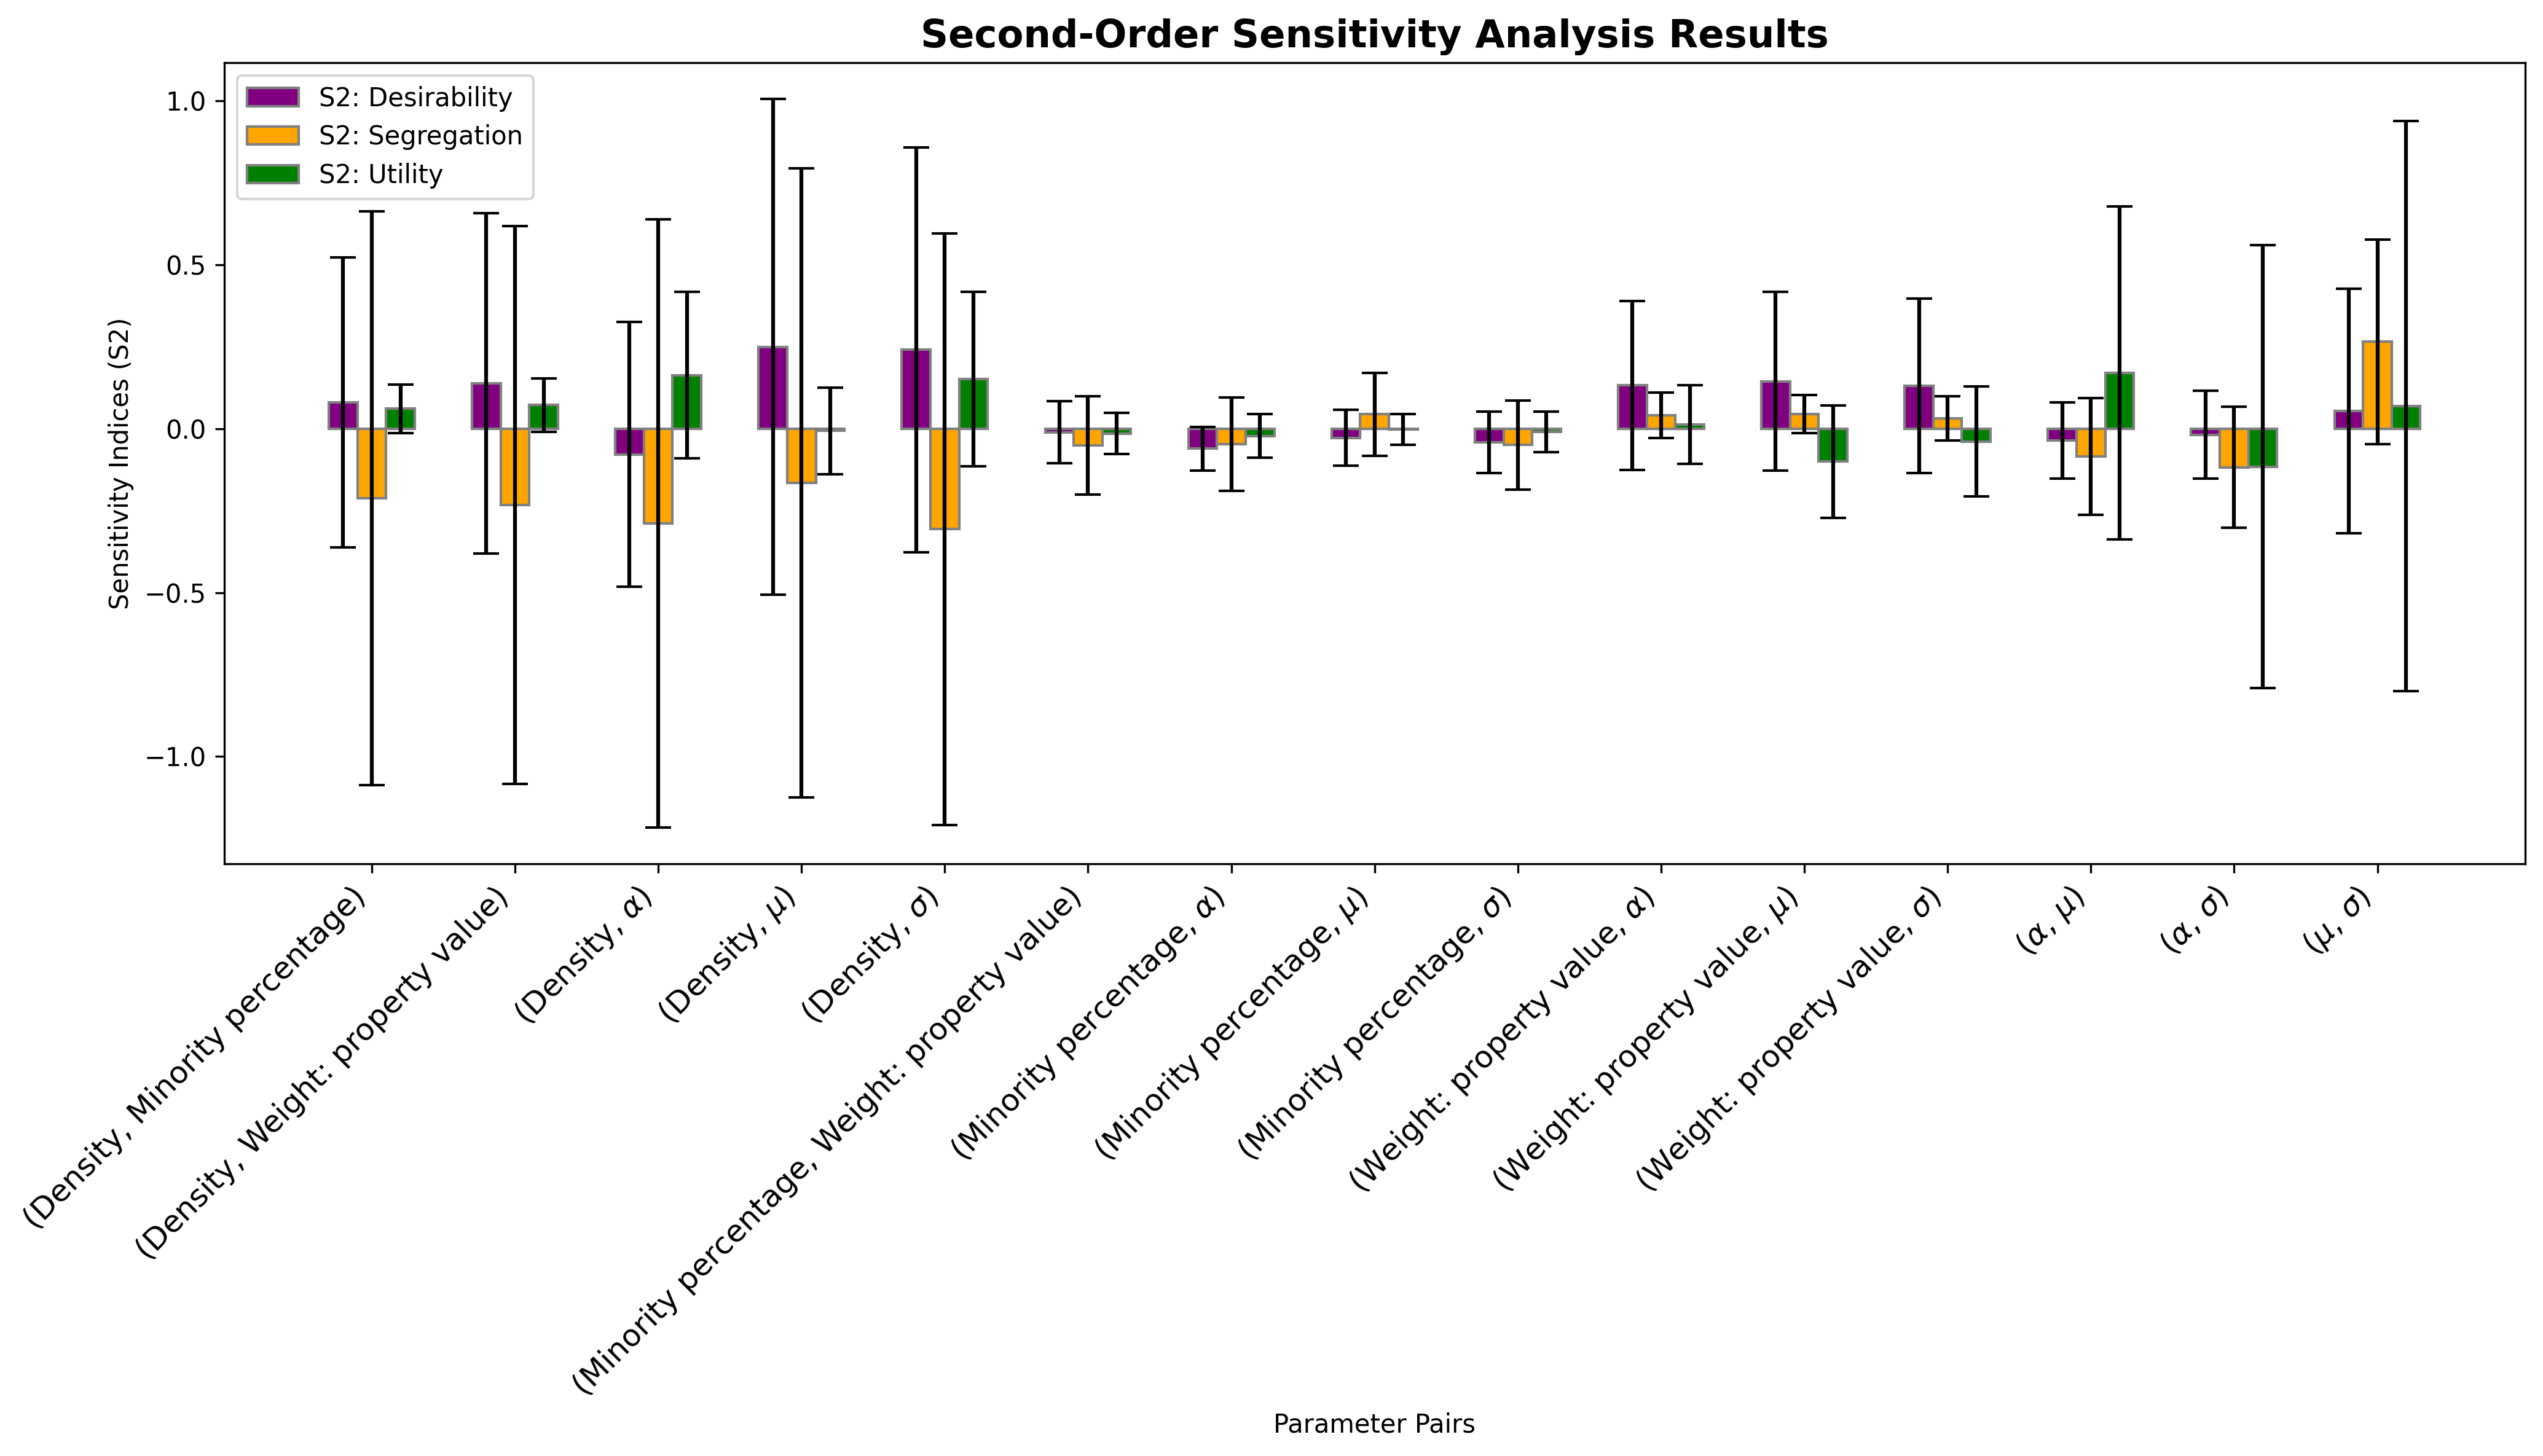

FileNotFoundError: [Errno 2] No such file or directory: 'figs/Second-Order Sensitivity Analysis Results.png'

<Figure size 640x480 with 0 Axes>

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# Sensitivity analysis results
pairs = [
    '(Density, Minority percentage)', 
    '(Density, Weight: property value)', 
    r'(Density, $\alpha$)', 
    r'(Density, $\mu$)', 
    r'(Density, $\sigma$)', 
    '(Minority percentage, Weight: property value)', 
    r'(Minority percentage, $\alpha$)', 
    r'(Minority percentage, $\mu$)', 
    r'(Minority percentage, $\sigma$)', 
    r'(Weight: property value, $\alpha$)', 
    r'(Weight: property value, $\mu$)', 
    r'(Weight: property value, $\sigma$)', 
    r'($\alpha$, $\mu$)', 
    r'($\alpha$, $\sigma$)', 
    r'($\mu$, $\sigma$)'
]
# Three sets of S2 values and their confidence intervals
S2_desirability = np.array(Si_desirability['S2'])
S2_desirability = S2_desirability[~np.isnan(S2_desirability)]
S2_conf_desirability = np.array(Si_desirability['S2_conf'])
S2_conf_desirability = S2_conf_desirability[~np.isnan(S2_conf_desirability)]

S2_agent = np.array(Si_agent['S2'])
S2_agent = S2_agent[~np.isnan(S2_agent)]
S2_conf_agent = np.array(Si_agent['S2_conf'])
S2_conf_agent = S2_conf_agent[~np.isnan(S2_conf_agent)]

S2_utility = np.array(Si_utility['S2'])
S2_utility = S2_utility[~np.isnan(S2_utility)]
S2_conf_utility = np.array(Si_utility['S2_conf'])
S2_conf_utility = S2_conf_utility[~np.isnan(S2_conf_utility)]

# Convert confidence intervals to errors (assuming symmetrical errors)
S2_1_err = np.array(S2_conf_desirability)
S2_2_err = np.array(S2_conf_agent)
S2_3_err = np.array(S2_conf_utility)

# Ensure all arrays are of the same length
assert len(pairs) == len(S2_desirability) == len(S2_conf_desirability) == len(S2_agent) == len(S2_conf_agent) == len(S2_utility) == len(S2_conf_utility), "All input arrays must have the same length"

# Bar width
bar_width = 0.2

# Positions of the bars
positions = np.arange(len(pairs))
r1 = positions - bar_width
r2 = positions
r3 = positions + bar_width


# Create the figure and axis
fig, ax = plt.subplots(dpi = 300, figsize=(14, 8))

# Plot with error bars
bars1 = ax.bar(r1, S2_desirability, yerr=S2_1_err, capsize=5, color='purple', width=bar_width, edgecolor='grey', label='S2: Desirability')
bars2 = ax.bar(r2, S2_agent, yerr=S2_2_err, capsize=5, color='orange', width=bar_width, edgecolor='grey', label='S2: Segregation')
bars3 = ax.bar(r3, S2_utility, yerr=S2_3_err, capsize=5, color='green', width=bar_width, edgecolor='grey', label='S2: Utility')

# Adding labels
ax.set_xlabel('Parameter Pairs', fontsize=10)
ax.set_ylabel('Sensitivity Indices (S2)', fontsize=10)
ax.set_title('Second-Order Sensitivity Analysis Results', fontweight='bold', fontsize=15)
ax.set_xticks(positions)
ax.set_xticklabels(pairs, rotation=45, ha='right', fontsize=12)

# Add a legend
ax.legend()

# Show the plot
plt.tight_layout()
plt.show()
save_figure(plt, f'Second-Order Sensitivity Analysis Results')
plt.close()

# Presentation Plots

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (15,) and arg 1 with shape (6,).

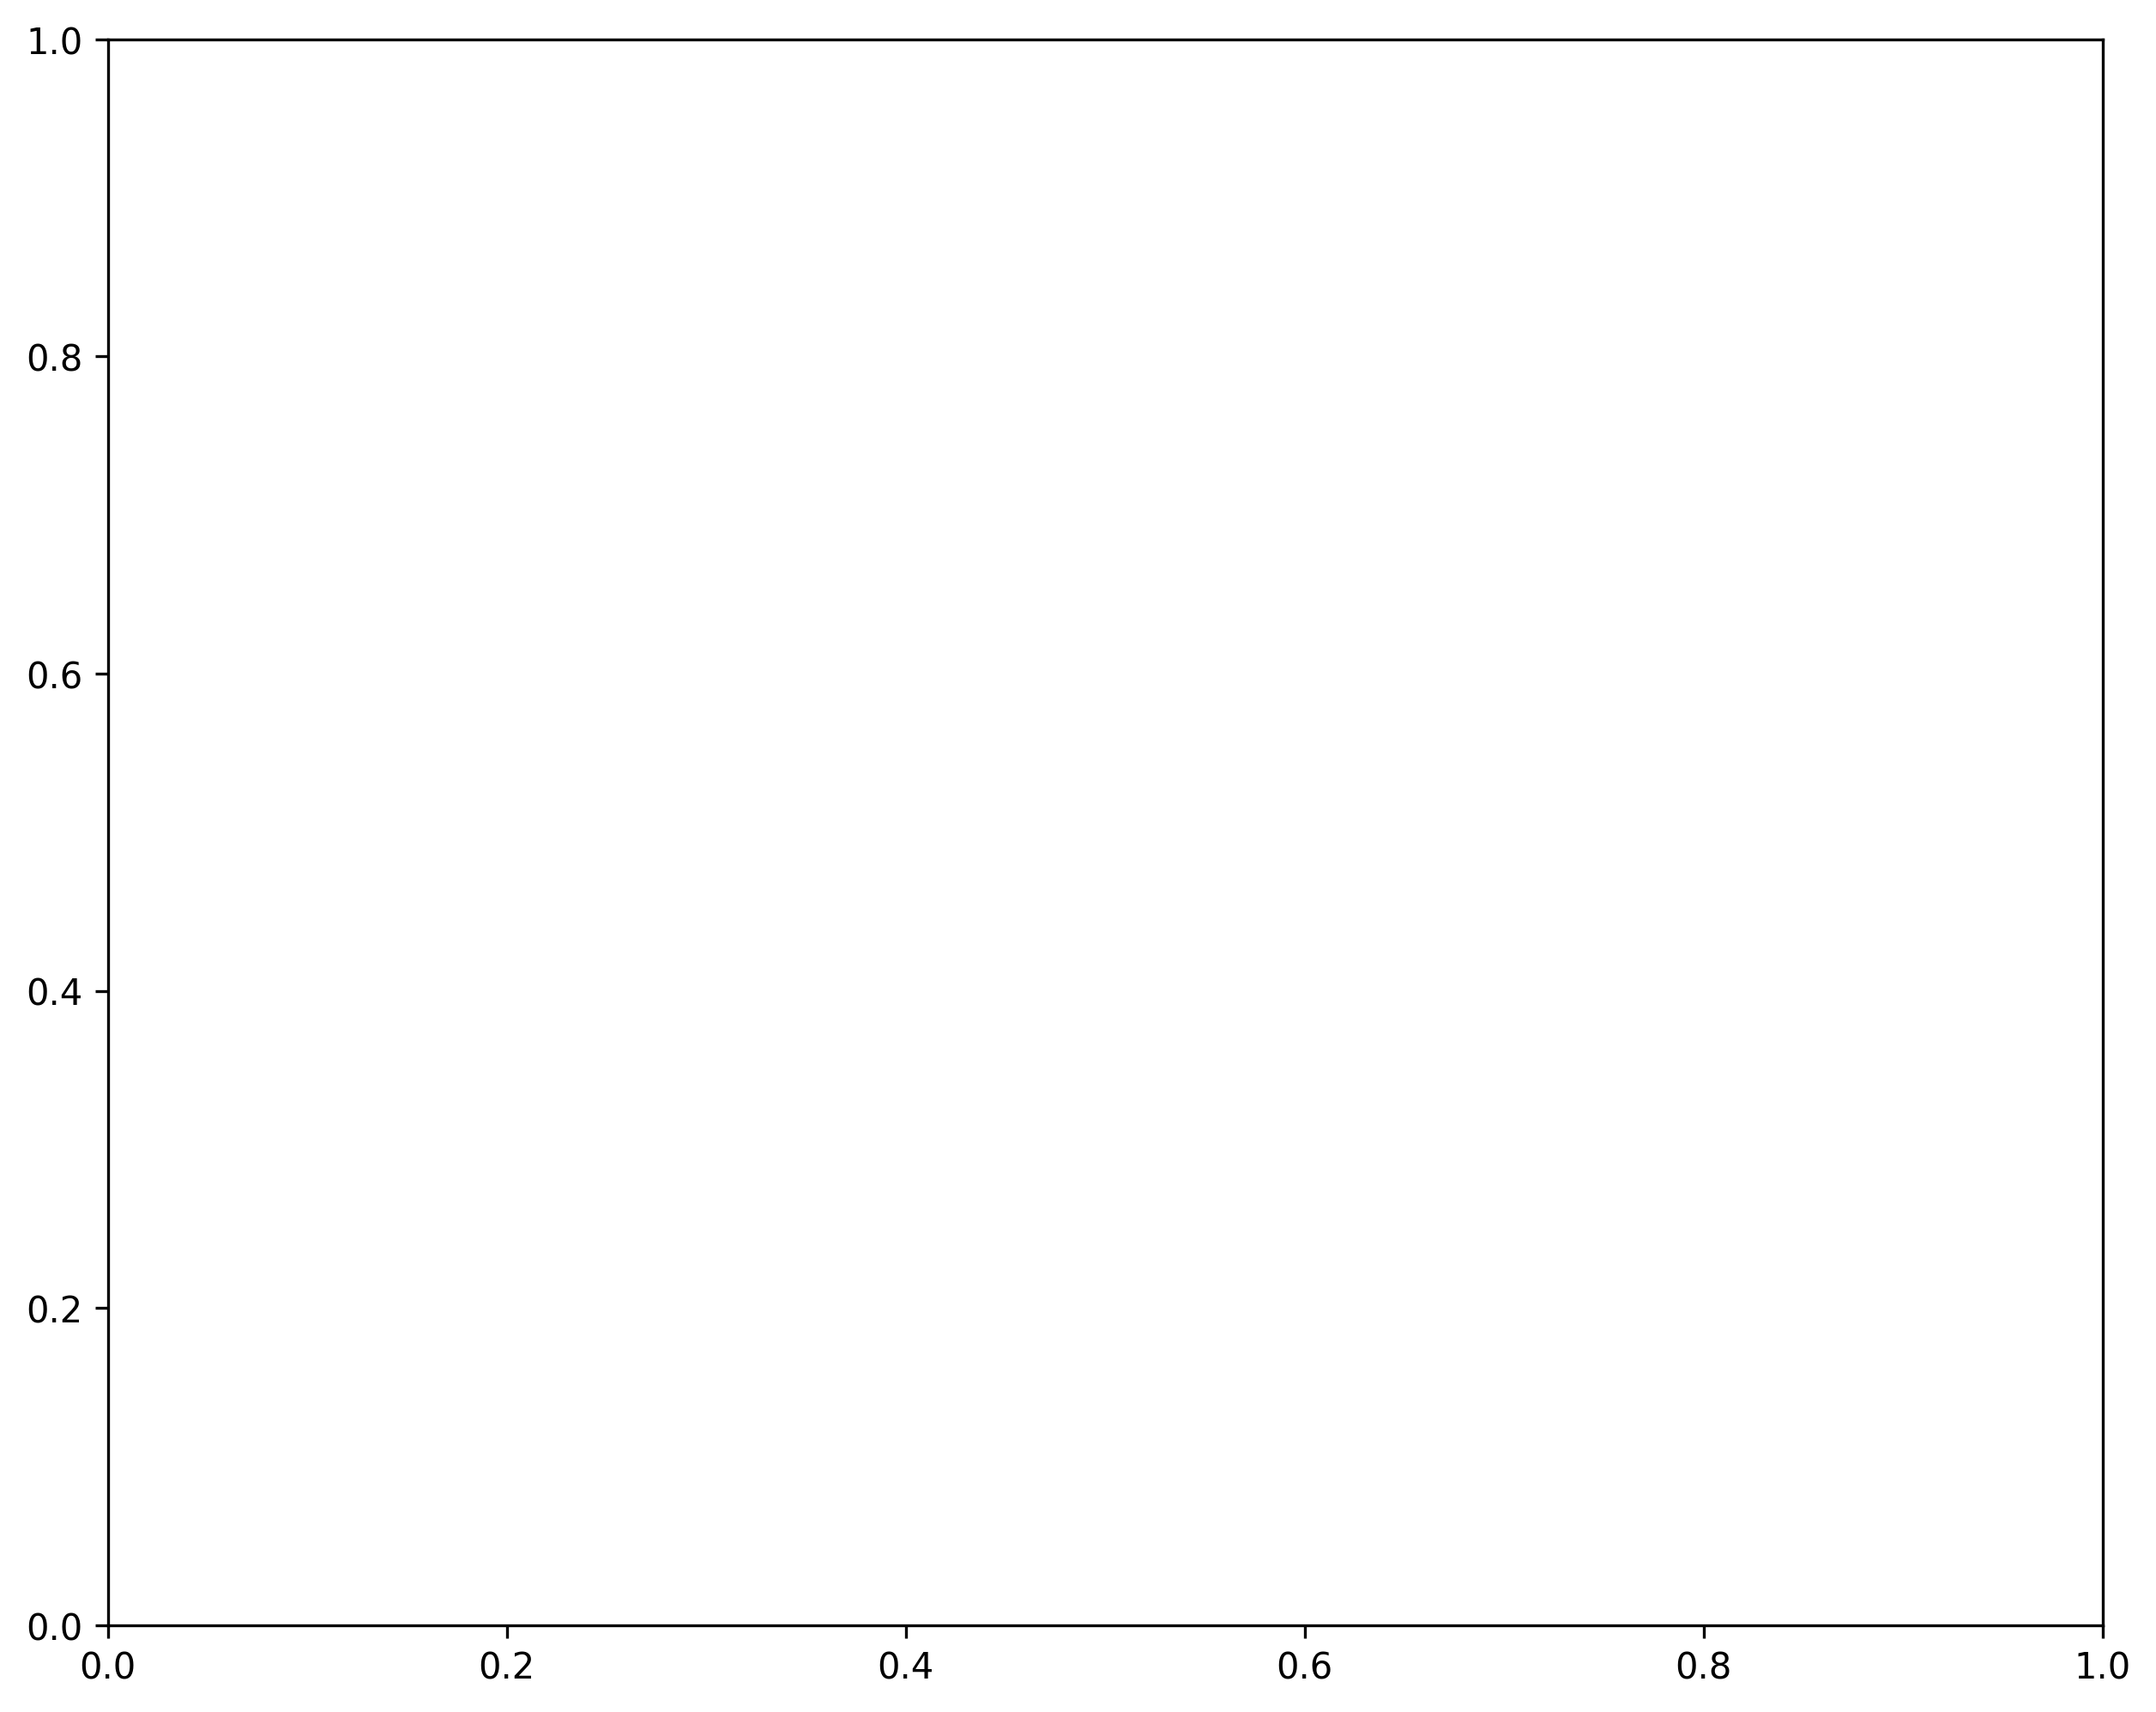

In [24]:
# Desirability 
fig, ax = plt.subplots(dpi = 300, figsize=(10, 8))
plt.bar(r1, S1_desirability, yerr=S1_err_desirability, capsize=5, color='#63d298ff', width=bar_width, edgecolor='grey', label='First order')
plt.bar(r2, ST_desirability, yerr=ST_err_desirability, capsize=5, color='#fff176ff', width=bar_width, edgecolor='grey', label='Total order')
ax.set_xlabel('Parameters', fontsize=10)
ax.set_ylabel('Sensitivity Indices', fontsize=10)
ax.set_title('Desirability', fontweight='bold', fontsize=15)
#axs[0].set_xticks([]) 
ax.set_xticks([r + bar_width/2 for r in range(len(params))])
ax.set_xticklabels(params, rotation=45, ha='right', fontsize=12)
plt.legend()
plt.tight_layout()
plt.show()
save_figure(plt, f'Desirability')
plt.close()

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (15,) and arg 1 with shape (6,).

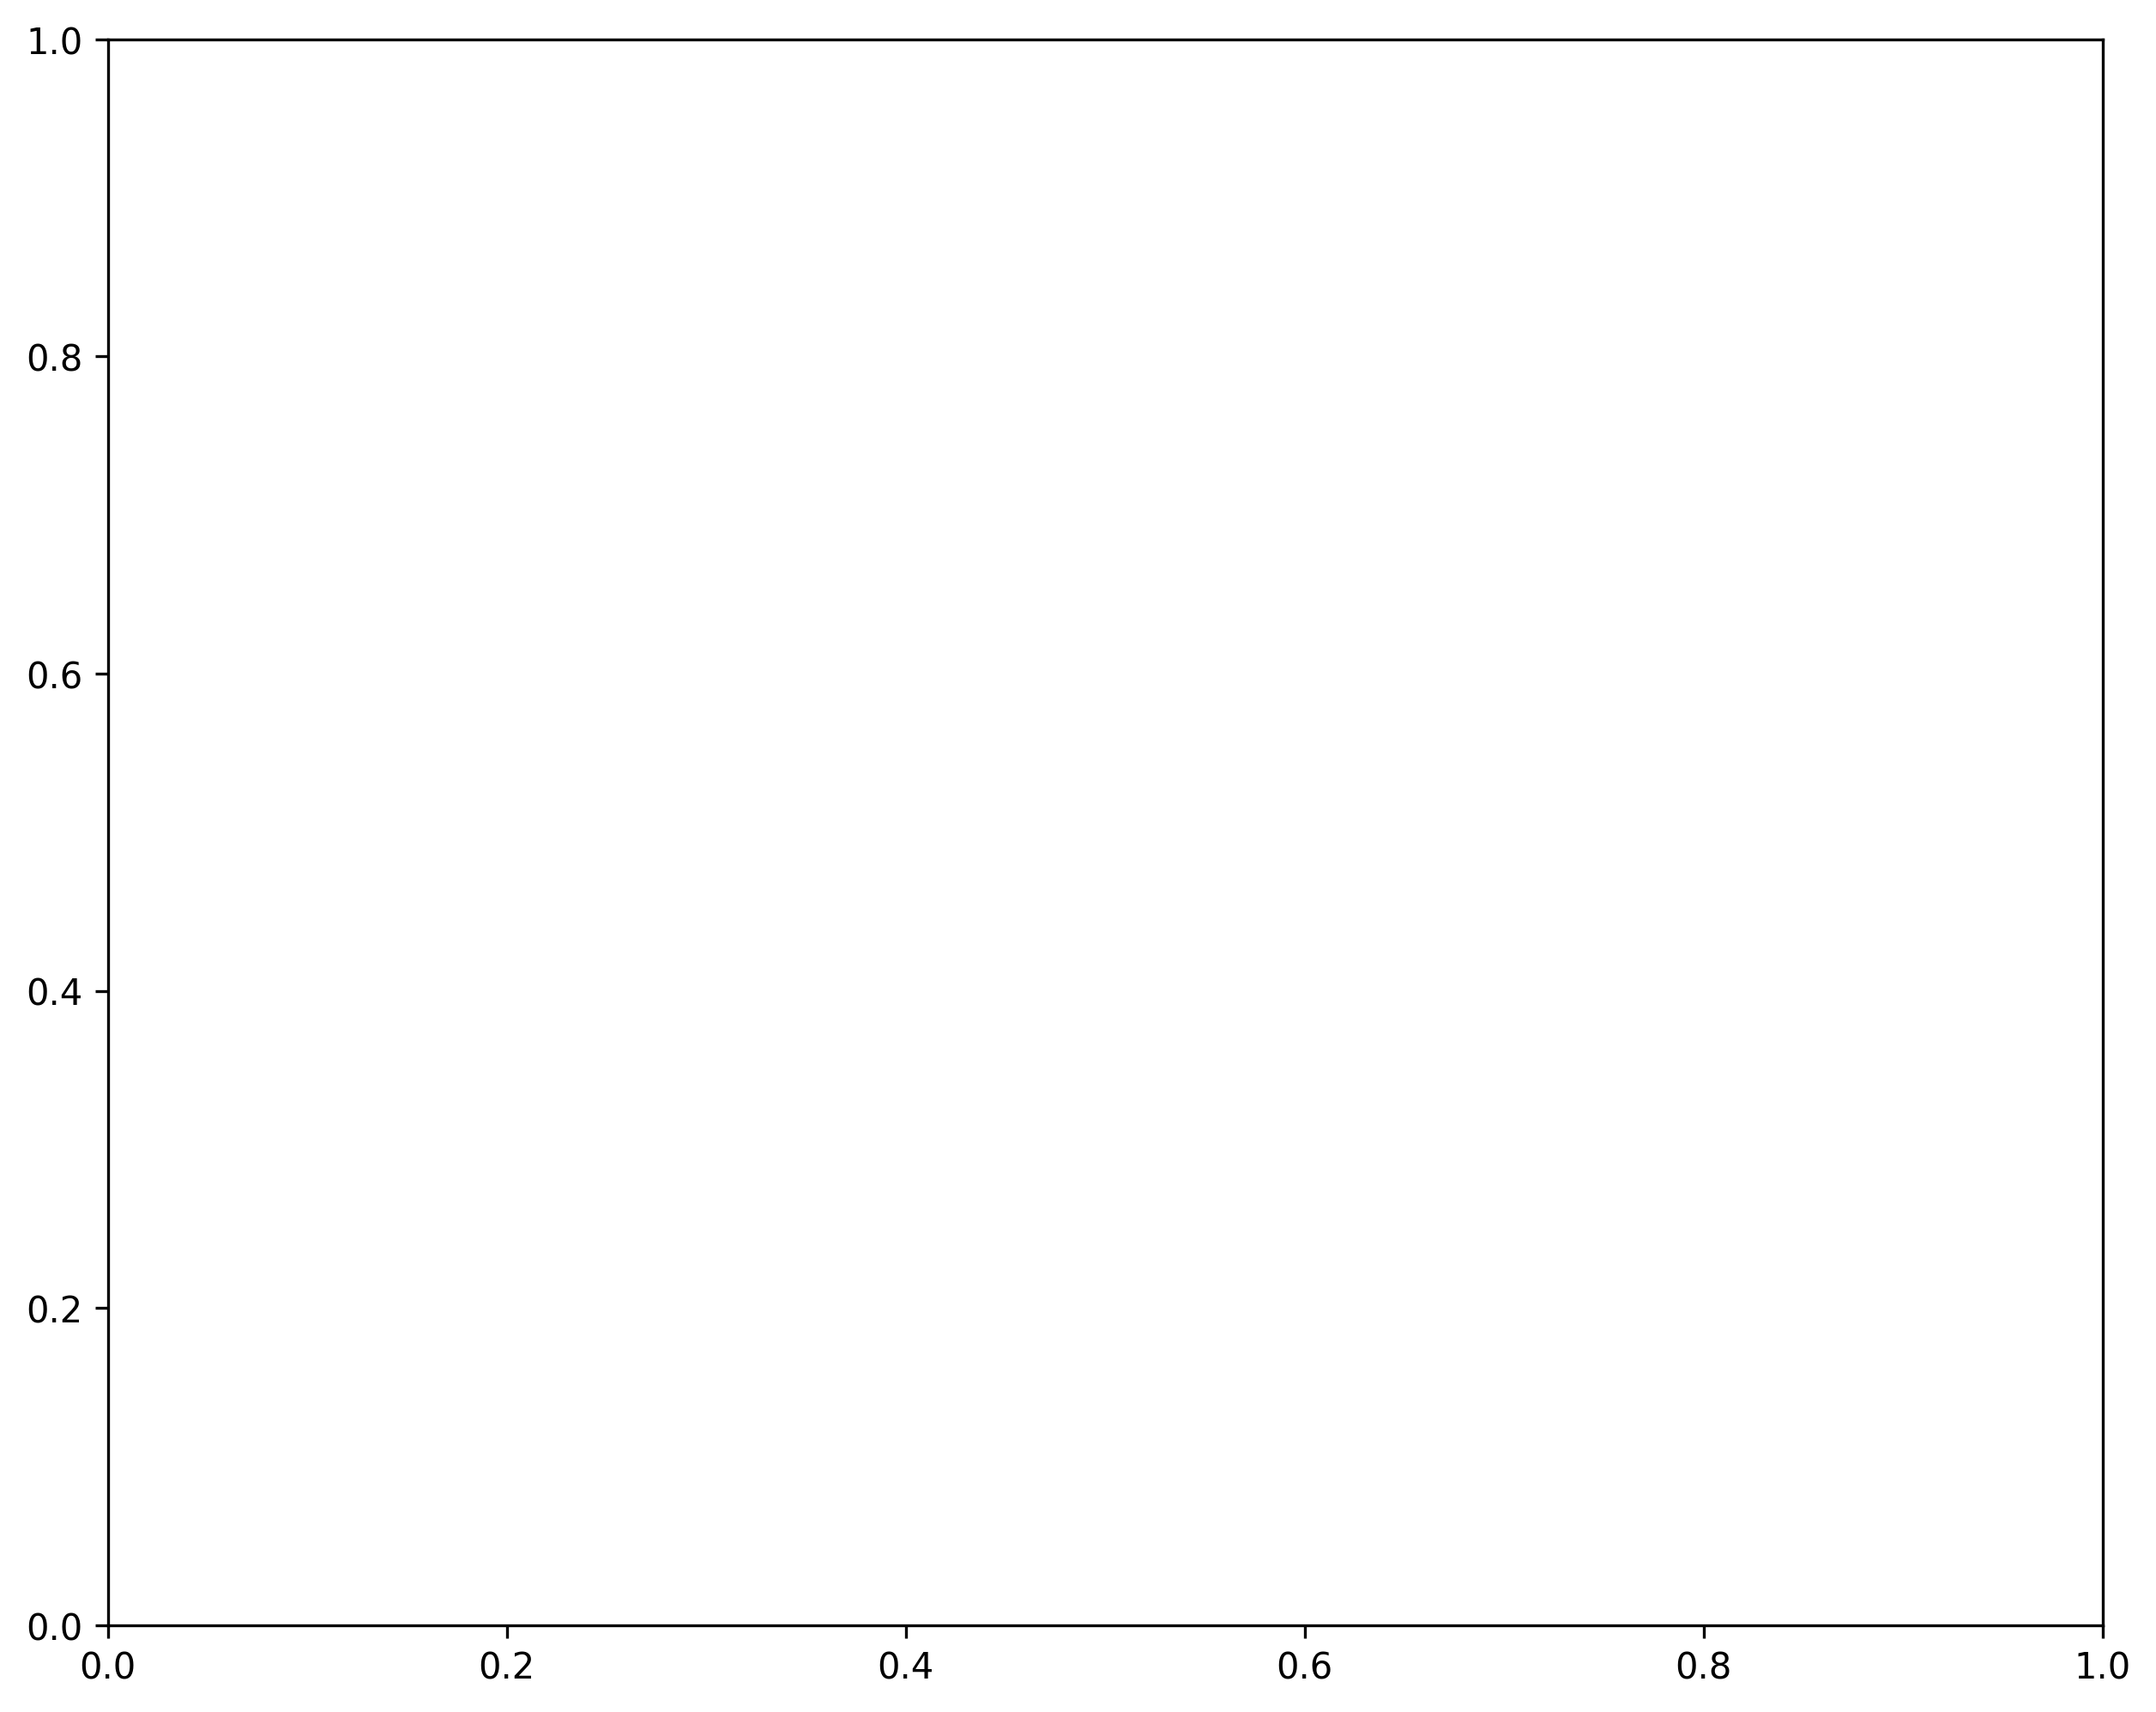

In [25]:
# Segregation subplot
fig, ax = plt.subplots(dpi = 300, figsize=(10, 8))
ax.bar(r1, S1_agent, yerr=S1_err_agent, capsize=5, color='#63d298ff', width=bar_width, edgecolor='grey', label='First order')
ax.bar(r2, ST_agent, yerr=ST_err_agent, capsize=5, color='#fff176ff', width=bar_width, edgecolor='grey', label='Total order')
ax.set_xlabel('Parameters', fontsize=10)
ax.set_ylabel('Sensitivity Indices', fontsize=10)
ax.set_title('Segregation', fontweight='bold', fontsize=15)
#ax.set_xticks([]) 
ax.set_xticks([r + bar_width/2 for r in range(len(params))])
ax.set_xticklabels(params, rotation=45, ha='right', fontsize=12)
ax.legend()
plt.tight_layout()
save_figure(plt, f'Segregation')
plt.close()

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (15,) and arg 1 with shape (6,).

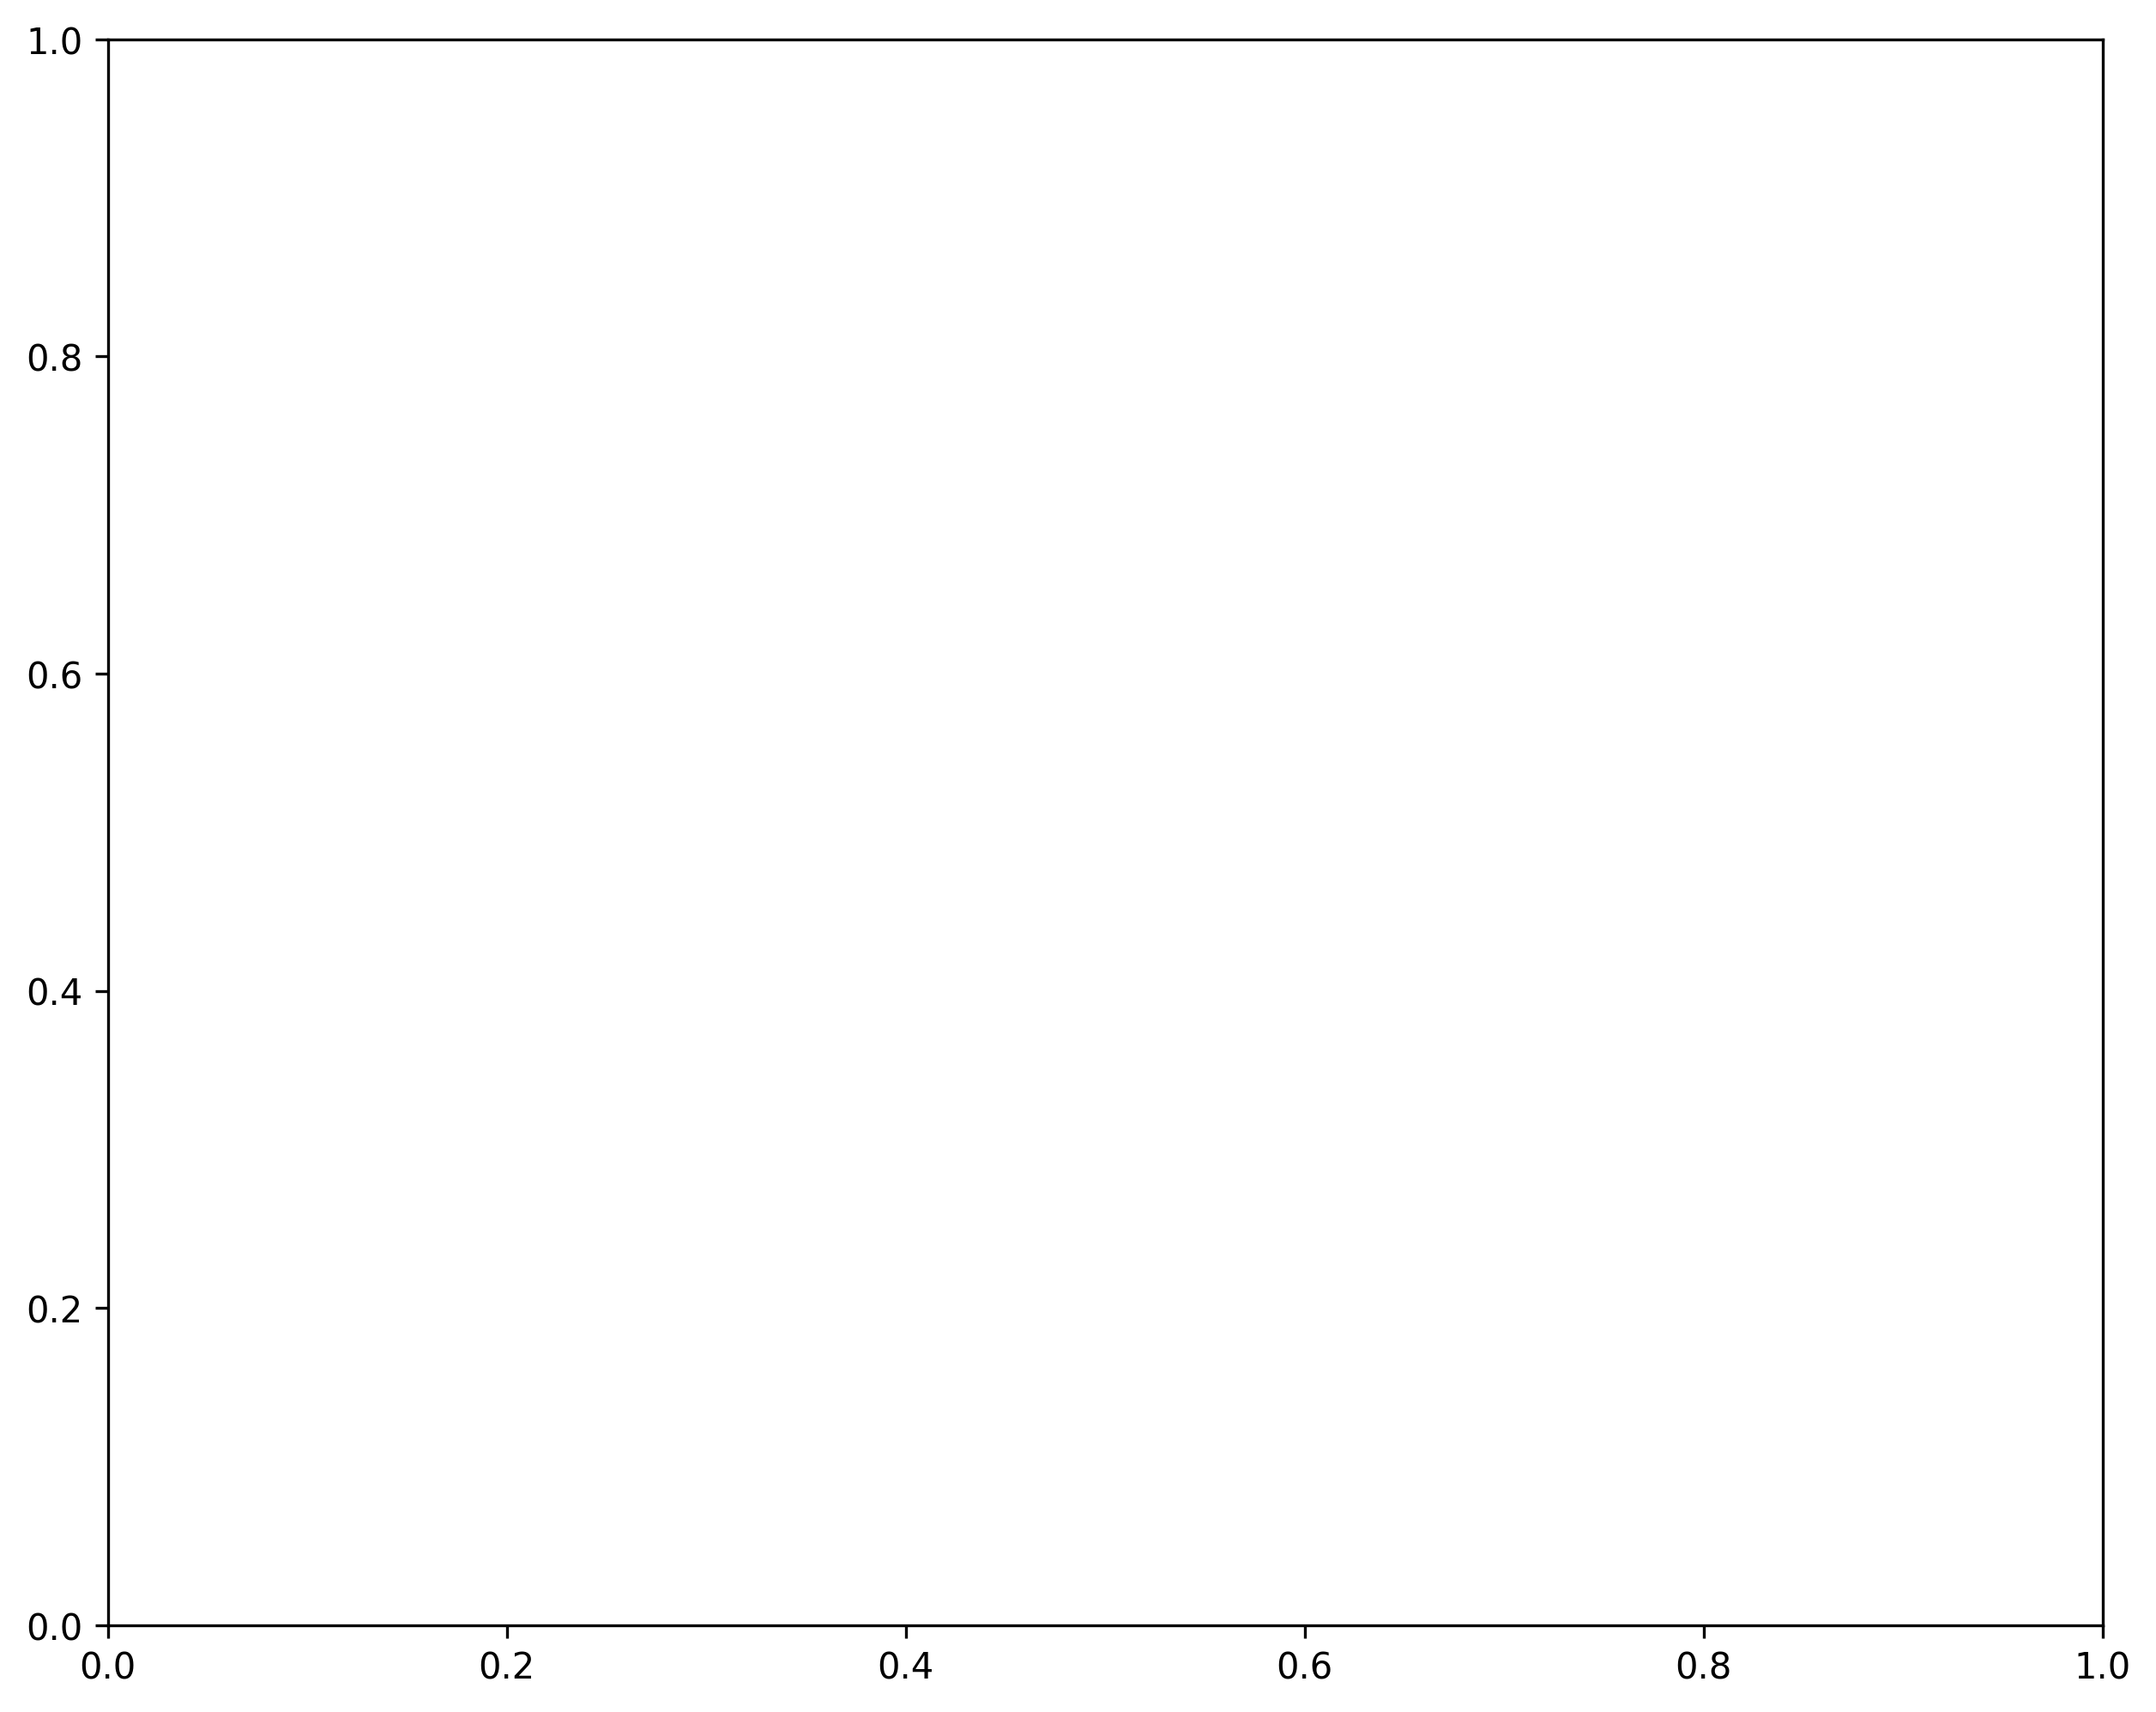

In [26]:
# Utility subplot
fig, ax = plt.subplots(dpi = 300, figsize=(10, 8))
ax.bar(r1, S1_utility, yerr=S1_err_utility, capsize=5, color='#63d298ff', width=bar_width, edgecolor='grey', label='First order')
ax.bar(r2, ST_utility, yerr=ST_err_utility, capsize=5, color='#fff176ff', width=bar_width, edgecolor='grey', label='Total order')
ax.set_xlabel('Parameters', fontsize=10)
ax.set_ylabel('Sensitivity Indices', fontsize=10)
ax.set_title('Utility', fontweight='bold', fontsize=15)
ax.set_xticks([r + bar_width/2 for r in range(len(params))])
ax.set_xticklabels(params, rotation=45, ha='right', fontsize=12)
ax.legend()

# Adjust layout
plt.tight_layout()
plt.show()
plt.close()